In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

import SimpleITK as sitk # To save the image

import viewscad

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr

SimpleGVXR 1.0.1 (2021-04-01T17:18:35) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-04-01T17:18:28) [Compiler: GNU g++] on Linux


We first create a CAD model using [OpenSCAD](https://openscad.org/) and extract the STL files

In [2]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fa=5, $fs=0.1);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([0, 0, offset])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [3]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([15, 70, 70])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [4]:
r = viewscad.Renderer()
r.render(openscad_matrix_str + openscad_make_spheres_str, outfile='matrix.stl')

In [5]:
openscad_cube_str = """

color("red")
    scale([15, 70, 70])
        cube(1, center = true);

"""

In [6]:
r = viewscad.Renderer()
r.render(openscad_cube_str, outfile='cube.stl')

The spheres

In [7]:
openscad_col_str_set = [];

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");");
        
    r = viewscad.Renderer()
    r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile='col_' + str(i) + '.stl')

In [8]:
json2gvxr.initGVXR("simulation.json");

Create an OpenGL context: 512x512


In [9]:
json2gvxr.initSourceGeometry();

Set up the beam
	Source position: [400, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [10]:
spectrum, unit = json2gvxr.initSpectrum();

In [22]:
print("kvp:", json2gvxr.params["Source"]["Beam"]["kvp"]);
print("filter material:", json2gvxr.params["Source"]["Beam"]["filter"][0]);
print("filter thickness (in mm):", json2gvxr.params["Source"]["Beam"]["filter"][1]); 

kvp: 80
filter material: Al
filter thickness (in mm): 4.0


Text(0.5, 1.0, 'X-ray spectrum')

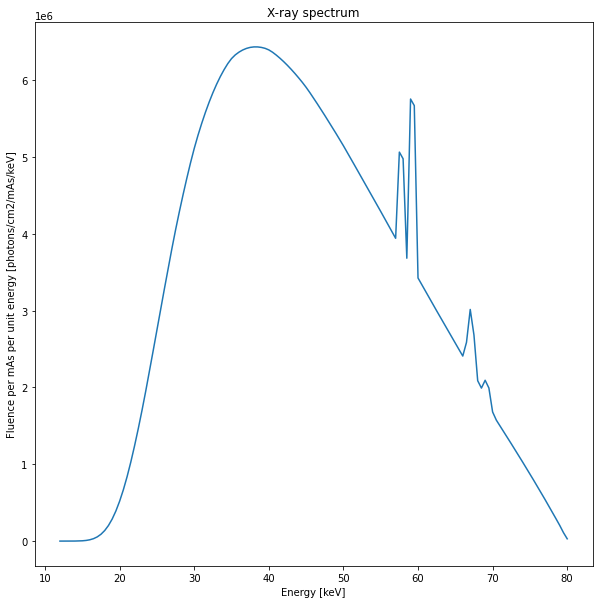

In [11]:
energy_set = sorted(spectrum.keys())
count_set = [];

for energy in energy_set:
    count_set.append(spectrum[energy])
    
plt.figure(figsize= (10,10))
plt.plot(energy_set, count_set) # Plot the spectrum
plt.xlabel('Energy [keV]')
plt.ylabel('Fluence per mAs per unit energy [photons/cm2/mAs/keV]')
plt.title('X-ray spectrum')

In [12]:
json2gvxr.initDetector();

Set up the detector
	Detector position: [-50, 0.0, 0.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [256, 256]
	Pixel spacing: [0.5, 0.5, 'mm']


In [13]:
json2gvxr.initSamples();

Load the 3D data
	Load matrix in cube.stl using mm
	Load Bone, Cortical (ICRU-44) in col_0.stl using mm
	Load Blood, Whole (ICRU-44) in col_1.stl using mm
	Load Brain, Grey/White Matter (ICRU-44) in col_2.stl using mm
	Load Breast Tissue (ICRU-44) in col_3.stl using mm
	Load Adipose Tissue (ICRU-44) in col_4.stl using mm


Compute an X-ray image and add it to the list of projections

In [14]:
x_ray_image = gvxr.computeXRayImage();

In [15]:
volume = sitk.GetImageFromArray(x_ray_image);
sitk.WriteImage(volume, 'projection.mha');

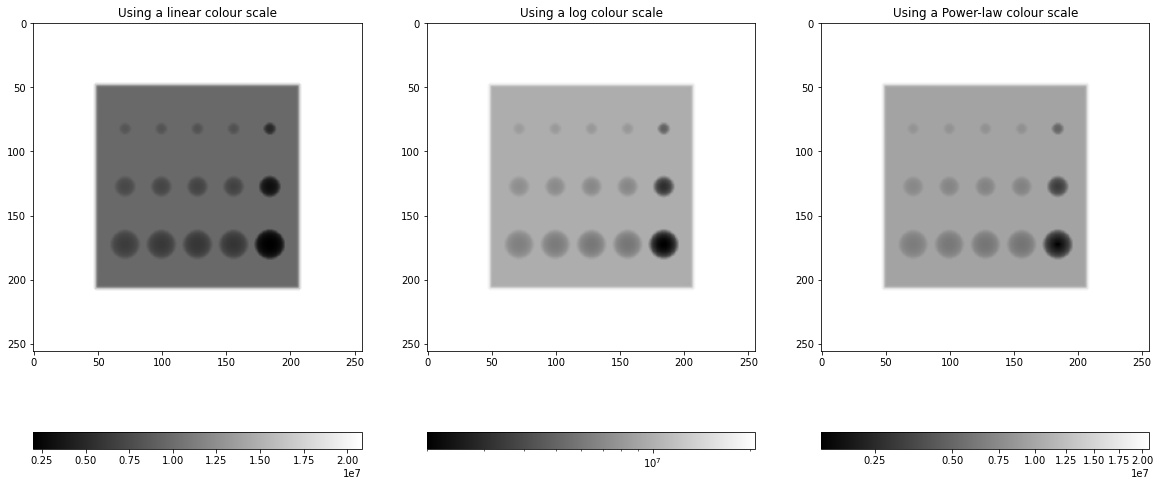

In [16]:
# Plot the projection
plt.figure(figsize= (20,10))
plt.subplot(131)
plt.imshow(x_ray_image, cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a linear colour scale");

plt.subplot(132)
plt.imshow(x_ray_image, norm=LogNorm(), cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a log colour scale");

plt.subplot(133)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./2.), cmap="gray");
plt.colorbar(orientation='horizontal');
plt.title("Using a Power-law colour scale");

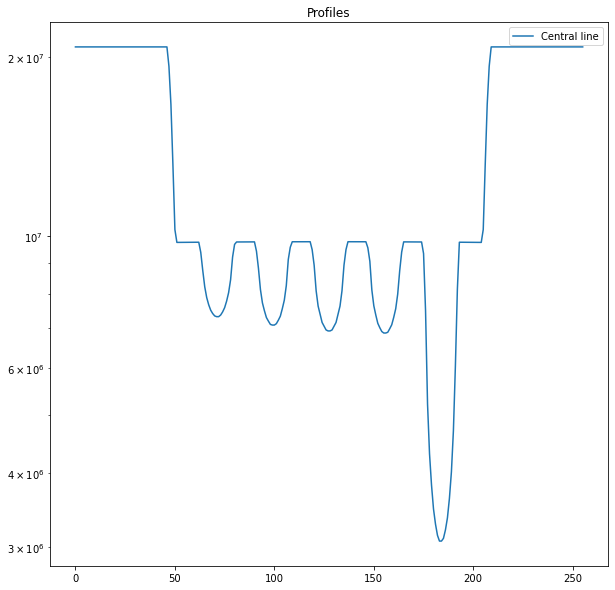

In [17]:
plt.figure(figsize= (10,10))
plt.title("Profiles");
plt.yscale("log")
plt.plot(x_ray_image[round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)], label="Central line")
plt.legend()

Update the 3D visualisation and take a screenshot

In [18]:
gvxr.displayScene();
screenshot = gvxr.takeScreenshot();

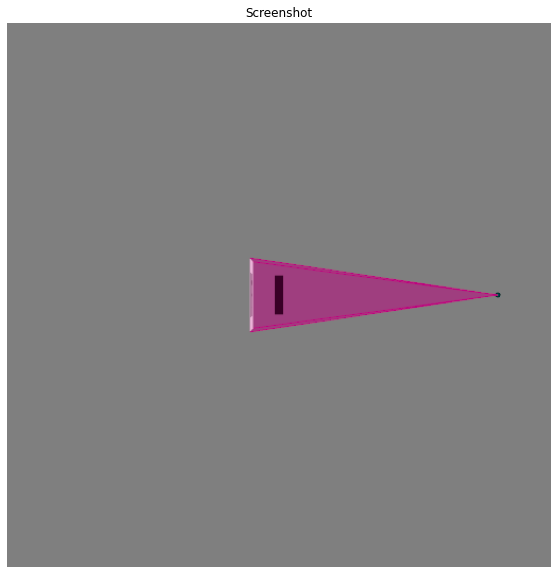

In [19]:
plt.figure(figsize= (10,10))
plt.title("Screenshot");
plt.imshow(screenshot);
plt.axis('off');

In [20]:
# Display the 3D scene (no event loop)
# Run an interactive loop
# (can rotate the 3D scene and zoom-in)
# Keys are:
# Q/Escape: to quit the event loop (does not close the window)
# B: display/hide the X-ray beam
# W: display the polygon meshes in solid or wireframe
# N: display the X-ray image in negative or positive
# H: display/hide the X-ray detector
# T: take a screenshot
gvxr.renderLoop();
screenshot = gvxr.getLatestScreenshot();

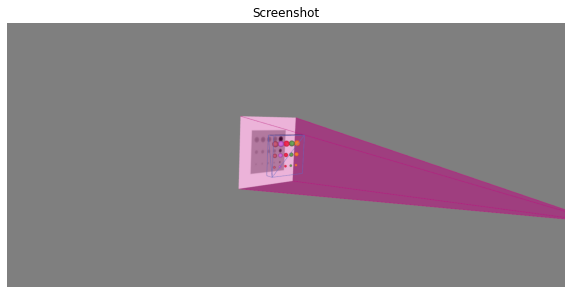

In [21]:
plt.figure(figsize= (10,10))
plt.title("Screenshot");
plt.imshow(screenshot);
plt.axis('off');